Начинаем обучение PINN для уравнения Ван дер Поля...
Эпоха 0, loss = 3.43e+03
Эпоха 500, loss = 1.10e-01
Эпоха 1000, loss = 8.59e-02
Эпоха 1500, loss = 8.20e-02
Эпоха 2000, loss = 8.07e-02
Эпоха 2500, loss = 7.98e-02
Эпоха 3000, loss = 7.92e-02
Эпоха 3500, loss = 7.87e-02
Эпоха 4000, loss = 7.83e-02
Эпоха 4500, loss = 8.96e-02


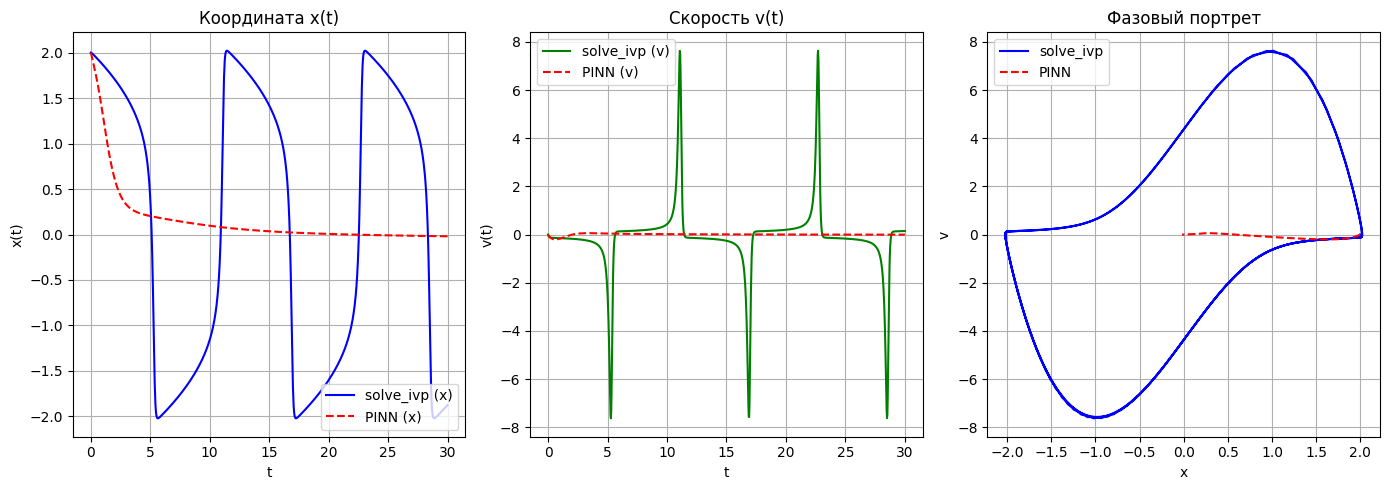

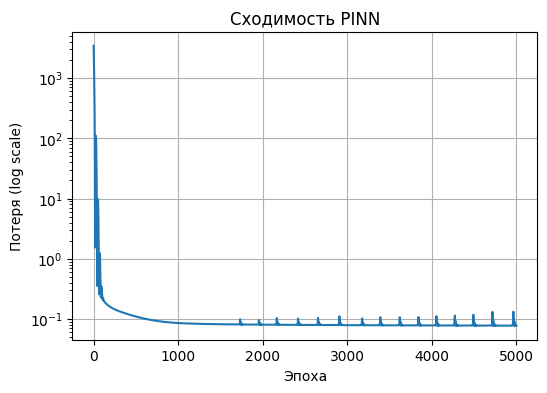

In [ ]:

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# -------------------------------
# 1. Численное решение (эталон)
# -------------------------------
mu = 5.0

def vdp_ode(t, z):
    x, v = z
    dxdt = v
    dvdt = mu * (1 - x**2) * v - x
    return [dxdt, dvdt]

# Решаем на [0, 30]
t_span = (0, 30)
t_eval = np.linspace(0, 30, 1000)
sol = solve_ivp(vdp_ode, t_span, [2.0, 0.0], t_eval=t_eval, rtol=1e-10, atol=1e-12)
t_num = torch.tensor(sol.t, dtype=torch.float32).unsqueeze(1)
x_num = torch.tensor(sol.y[0], dtype=torch.float32)
v_num = torch.tensor(sol.y[1], dtype=torch.float32)

# -------------------------------
# 2. PINN на чистом PyTorch
# -------------------------------

class VdP_PINN(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 2)  # [x(t), v(t)]
        )

    def forward(self, t):
        return self.net(t)

# Устройство
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Модель и оптимизатор
model = VdP_PINN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Обучающие точки (внутренние)
t_train = torch.linspace(0, 30, 600, requires_grad=True).unsqueeze(1).to(device)

# Параметры ранней остановки
best_loss = float('inf')
patience = 100
patience_counter = 0
min_delta = 1e-6
max_epochs = 5000

# Лог потерь
losses = []

print("Начинаем обучение PINN для уравнения Ван дер Поля...")

for epoch in range(max_epochs):
    optimizer.zero_grad()

    # Прямой проход
    out = model(t_train)
    x, v = out[:, 0:1], out[:, 1:2]

    # Градиенты по времени
    dx_dt = torch.autograd.grad(x, t_train, grad_outputs=torch.ones_like(x), create_graph=True)[0]
    dv_dt = torch.autograd.grad(v, t_train, grad_outputs=torch.ones_like(v), create_graph=True)[0]

    # Остатки уравнений
    f1 = dx_dt - v
    f2 = dv_dt - (mu * (1 - x**2) * v - x)

    loss_ode = torch.mean(f1**2 + f2**2)

    # Начальные условия
    t0 = torch.tensor([[0.0]], device=device)
    out0 = model(t0)
    x0, v0 = out0[0, 0], out0[0, 1]
    loss_ic = (x0 - 2.0)**2 + (v0 - 0.0)**2

    # Общая потеря (усиливаем IC)
    loss = loss_ode + 1000.0 * loss_ic

    loss.backward()
    optimizer.step()

    loss_val = loss.item()
    losses.append(loss_val)

    # Ранняя остановка
    if loss_val < best_loss - min_delta:
        best_loss = loss_val
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Ранняя остановка на эпохе {epoch + 1}, loss = {loss_val:.2e}")
        break

    if epoch % 500 == 0:
        print(f"Эпоха {epoch}, loss = {loss_val:.2e}")

# -------------------------------
# 3. Оценка и визуализация
# -------------------------------

# Оценка на плотной сетке
t_test = torch.linspace(0, 30, 1000).unsqueeze(1).to(device)
model.eval()
with torch.no_grad():
    pred = model(t_test)
x_pred = pred[:, 0].cpu().numpy()
v_pred = pred[:, 1].cpu().numpy()
t_test_cpu = t_test.cpu().numpy().flatten()

# Переводим численное решение в numpy
t_num_cpu = t_num.numpy().flatten()
x_num_cpu = x_num.numpy()
v_num_cpu = v_num.numpy()

# Графики
plt.figure(figsize=(14, 5))

# x(t)
plt.subplot(1, 3, 1)
plt.plot(t_num_cpu, x_num_cpu, 'b', label='solve_ivp (x)')
plt.plot(t_test_cpu, x_pred, 'r--', label='PINN (x)')
plt.xlabel('t')
plt.ylabel('x(t)')
plt.title('Координата x(t)')
plt.grid(True)
plt.legend()

# v(t)
plt.subplot(1, 3, 2)
plt.plot(t_num_cpu, v_num_cpu, 'g', label='solve_ivp (v)')
plt.plot(t_test_cpu, v_pred, 'r--', label='PINN (v)')
plt.xlabel('t')
plt.ylabel('v(t)')
plt.title('Скорость v(t)')
plt.grid(True)
plt.legend()

# Фазовый портрет
plt.subplot(1, 3, 3)
plt.plot(x_num_cpu, v_num_cpu, 'b', label='solve_ivp')
plt.plot(x_pred, v_pred, 'r--', label='PINN')
plt.xlabel('x')
plt.ylabel('v')
plt.title('Фазовый портрет')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# График потерь
plt.figure(figsize=(6, 4))
plt.plot(losses)
plt.xlabel('Эпоха')
plt.ylabel('Потеря (log scale)')
plt.yscale('log')
plt.title('Сходимость PINN')
plt.grid(True)
plt.show()

Обучение MLP...
  MLP: эпоха 0, loss = 3.89e+04
  MLP: эпоха 1000, loss = 1.09e-01
  MLP: эпоха 2000, loss = 9.00e-02
  MLP завершено. Финальный loss = 8.24e-02
Обучение FFN...
  FFN: эпоха 0, loss = 2.17e+04
  FFN завершено. Финальный loss = 6.12e+00
Обучение SIREN...
  SIREN: эпоха 0, loss = 1.54e+04
  SIREN: эпоха 1000, loss = 2.24e-01
  SIREN завершено. Финальный loss = 3.02e-02


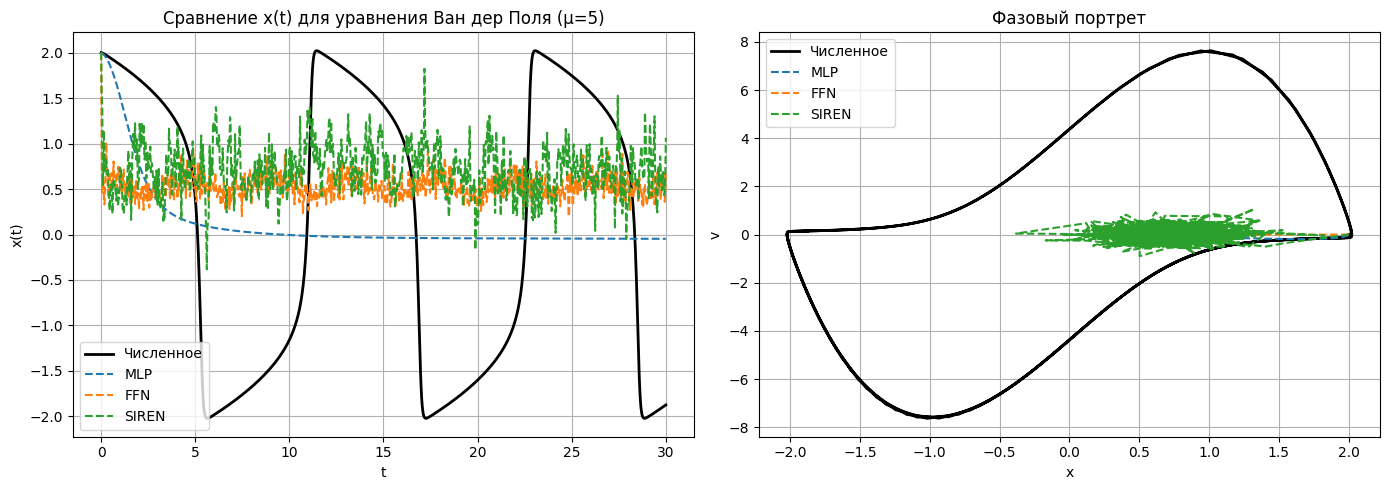

In [ ]:

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# -------------------------------
# 1. Численное решение (эталон)
# -------------------------------
mu = 5.0

def vdp_ode(t, z):
    x, v = z
    return [v, mu * (1 - x**2) * v - x]

t_span = (0, 30)
t_eval = np.linspace(0, 30, 1000)
sol = solve_ivp(vdp_ode, t_span, [2.0, 0.0], t_eval=t_eval, rtol=1e-12, atol=1e-14)
t_num = sol.t
x_num = sol.y[0]
v_num = sol.y[1]

# -------------------------------
# 2. Архитектуры
# -------------------------------

# === MLP ===
class MLP(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 2)
        )
    def forward(self, t):
        return self.net(t)

# === Fourier Features ===
class FourierFeatures(nn.Module):
    def __init__(self, input_dim=1, num_features=25, scale=15.0):
        super().__init__()
        self.register_buffer('B', torch.randn(input_dim, num_features) * scale)
    def forward(self, x):
        x_proj = 2 * np.pi * x @ self.B
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

class FFN(nn.Module):
    def __init__(self, num_features=25, hidden_dim=128, scale=15.0):
        super().__init__()
        self.embed = FourierFeatures(input_dim=1, num_features=num_features, scale=scale)
        self.net = nn.Sequential(
            nn.Linear(2 * num_features, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2)
        )
    def forward(self, t):
        return self.net(self.embed(t))

# === SIREN ===
class SineLayer(nn.Module):
    def __init__(self, in_f, out_f, is_first=False, omega_0=30.0):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        self.linear = nn.Linear(in_f, out_f)
        self.init_weights()
    def init_weights(self):
        with torch.no_grad():
            if self.is_incremental_first:
                self.linear.weight.uniform_(-1 / self.linear.in_features,
                                            1 / self.linear.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.linear.in_features) / self.omega_0,
                                            np.sqrt(6 / self.linear.in_features) / self.omega_0)
    def forward(self, x):
        return torch.sin(self.omega_0 * self.linear(x))

# Исправляем ошибку в имени атрибута
class SIREN(nn.Module):
    def __init__(self, hidden_dim=128, omega_0=30.0):
        super().__init__()
        self.omega_0 = omega_0
        self.net = nn.Sequential(
            SineLayer(1, hidden_dim, is_first=True, omega_0=omega_0),
            SineLayer(hidden_dim, hidden_dim, is_first=False, omega_0=omega_0),
            SineLayer(hidden_dim, hidden_dim, is_first=False, omega_0=omega_0),
            nn.Linear(hidden_dim, 2)
        )
        with torch.no_grad():
            self.net[-1].weight.uniform_(-np.sqrt(6 / hidden_dim), np.sqrt(6 / hidden_dim))
    def forward(self, t):
        return self.net(t)

# Исправляем SineLayer: убираем битый атрибут
class SineLayer(nn.Module):
    def __init__(self, in_f, out_f, is_first=False, omega_0=30.0):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        self.in_f = in_f
        self.linear = nn.Linear(in_f, out_f)
        self.init_weights()
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_f, 1 / self.in_f)
            else:
                self.linear.weight.uniform_(
                    -np.sqrt(6 / self.in_f) / self.omega_0,
                    np.sqrt(6 / self.in_f) / self.omega_0
                )
    def forward(self, x):
        return torch.sin(self.omega_0 * self.linear(x))

# -------------------------------
# 3. Функция обучения одной модели
# -------------------------------
def train_pinn(model, name, device, t_train, mu=5.0, max_epochs=3000, lr=1e-3, ic_weight=1e4):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_loss = float('inf')
    patience = 80
    counter = 0
    print(f"Обучение {name}...")

    for epoch in range(max_epochs):
        optimizer.zero_grad()
        t = t_train.clone().requires_grad_(True)
        out = model(t)
        x, v = out[:, 0:1], out[:, 1:2]

        # Производные
        dx = torch.autograd.grad(x, t, grad_outputs=torch.ones_like(x), create_graph=True)[0]
        dv = torch.autograd.grad(v, t, grad_outputs=torch.ones_like(v), create_graph=True)[0]

        # Остатки
        f1 = dx - v
        f2 = dv - (mu * (1 - x**2) * v - x)
        loss_ode = torch.mean(f1**2 + f2**2)

        # Начальные условия
        ic = model(torch.tensor([[0.0]], device=device))
        loss_ic = (ic[0,0] - 2.0)**2 + (ic[0,1] - 0.0)**2

        loss = loss_ode + ic_weight * loss_ic
        loss.backward()
        optimizer.step()

        # Ранняя остановка
        if loss.item() < best_loss - 1e-7:
            best_loss = loss.item()
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                break
        if epoch % 1000 == 0:
            print(f"  {name}: эпоха {epoch}, loss = {loss.item():.2e}")
    print(f"  {name} завершено. Финальный loss = {loss.item():.2e}")
    return model

# -------------------------------
# 4. Подготовка данных и обучение
# -------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
t_train = torch.linspace(0, 30, 600).unsqueeze(1).to(device)

# Создаём и обучаем модели
models = {}
models['MLP'] = train_pinn(MLP(hidden_dim=64), 'MLP', device, t_train, lr=1e-3, ic_weight=1e4)
models['FFN'] = train_pinn(FFN(num_features=25, hidden_dim=128, scale=15.0), 'FFN', device, t_train, lr=1e-3, ic_weight=5e3)
models['SIREN'] = train_pinn(SIREN(hidden_dim=128, omega_0=30.0), 'SIREN', device, t_train, lr=1e-4, ic_weight=1e4)

# -------------------------------
# 5. Оценка и визуализация
# -------------------------------
t_test = torch.linspace(0, 30, 1000).unsqueeze(1).to(device)
results = {'Численное': (x_num, v_num)}

with torch.no_grad():
    for name, model in models.items():
        pred = model(t_test)
        x = pred[:, 0].cpu().numpy()
        v = pred[:, 1].cpu().numpy()
        results[name] = (x, v)

t_test_cpu = t_test.cpu().numpy().flatten()

# График x(t)
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(t_num, x_num, 'k-', linewidth=2, label='Численное')
for name, (x, v) in results.items():
    if name != 'Численное':
        plt.plot(t_test_cpu, x, '--', label=name)
plt.xlabel('t')
plt.ylabel('x(t)')
plt.title('Сравнение x(t) для уравнения Ван дер Поля (μ=5)')
plt.legend()
plt.grid(True)

# Фазовый портрет
plt.subplot(1, 2, 2)
plt.plot(x_num, v_num, 'k-', linewidth=2, label='Численное')
for name, (x, v) in results.items():
    if name != 'Численное':
        plt.plot(x, v, '--', label=name)
plt.xlabel('x')
plt.ylabel('v')
plt.title('Фазовый портрет')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Используемое устройство: cpu


Обучение MLP (Tanh)
  Эпоха    0: loss = nan, loss_ode = nan, loss_ic = 4.044e+00, LR = 1.0e-03


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:1343: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  current = float(metrics)


  → Ранняя остановка на эпохе 99
  MLP (Tanh) завершено за 99 эпох
  Финальный loss = nan
  Лучший loss = inf


Обучение FFN (Fourier Features)
  Эпоха    0: loss = nan, loss_ode = nan, loss_ic = 3.974e+00, LR = 1.0e-03
  → Ранняя остановка на эпохе 99
  FFN (Fourier Features) завершено за 99 эпох
  Финальный loss = nan
  Лучший loss = inf


Обучение SIREN
  Эпоха    0: loss = nan, loss_ode = nan, loss_ic = 5.946e+00, LR = 1.0e-04
  → Ранняя остановка на эпохе 99
  SIREN завершено за 99 эпох
  Финальный loss = nan
  Лучший loss = inf

Получение предсказаний моделей...
  MLP: предсказания получены
  FFN: предсказания получены
  SIREN: предсказания получены

Ошибки предсказаний (L2 норма):
------------------------------------------------------------
  MLP                      : error_x = 2.3703e+00, error_v = 1.5498e+00, total = 2.8320e+00
  FFN                      : error_x = 1.6738e+00, error_v = 1.5540e+00, total = 2.2840e+00
  SIREN                    : error_x = 3.0660e+00, error_v

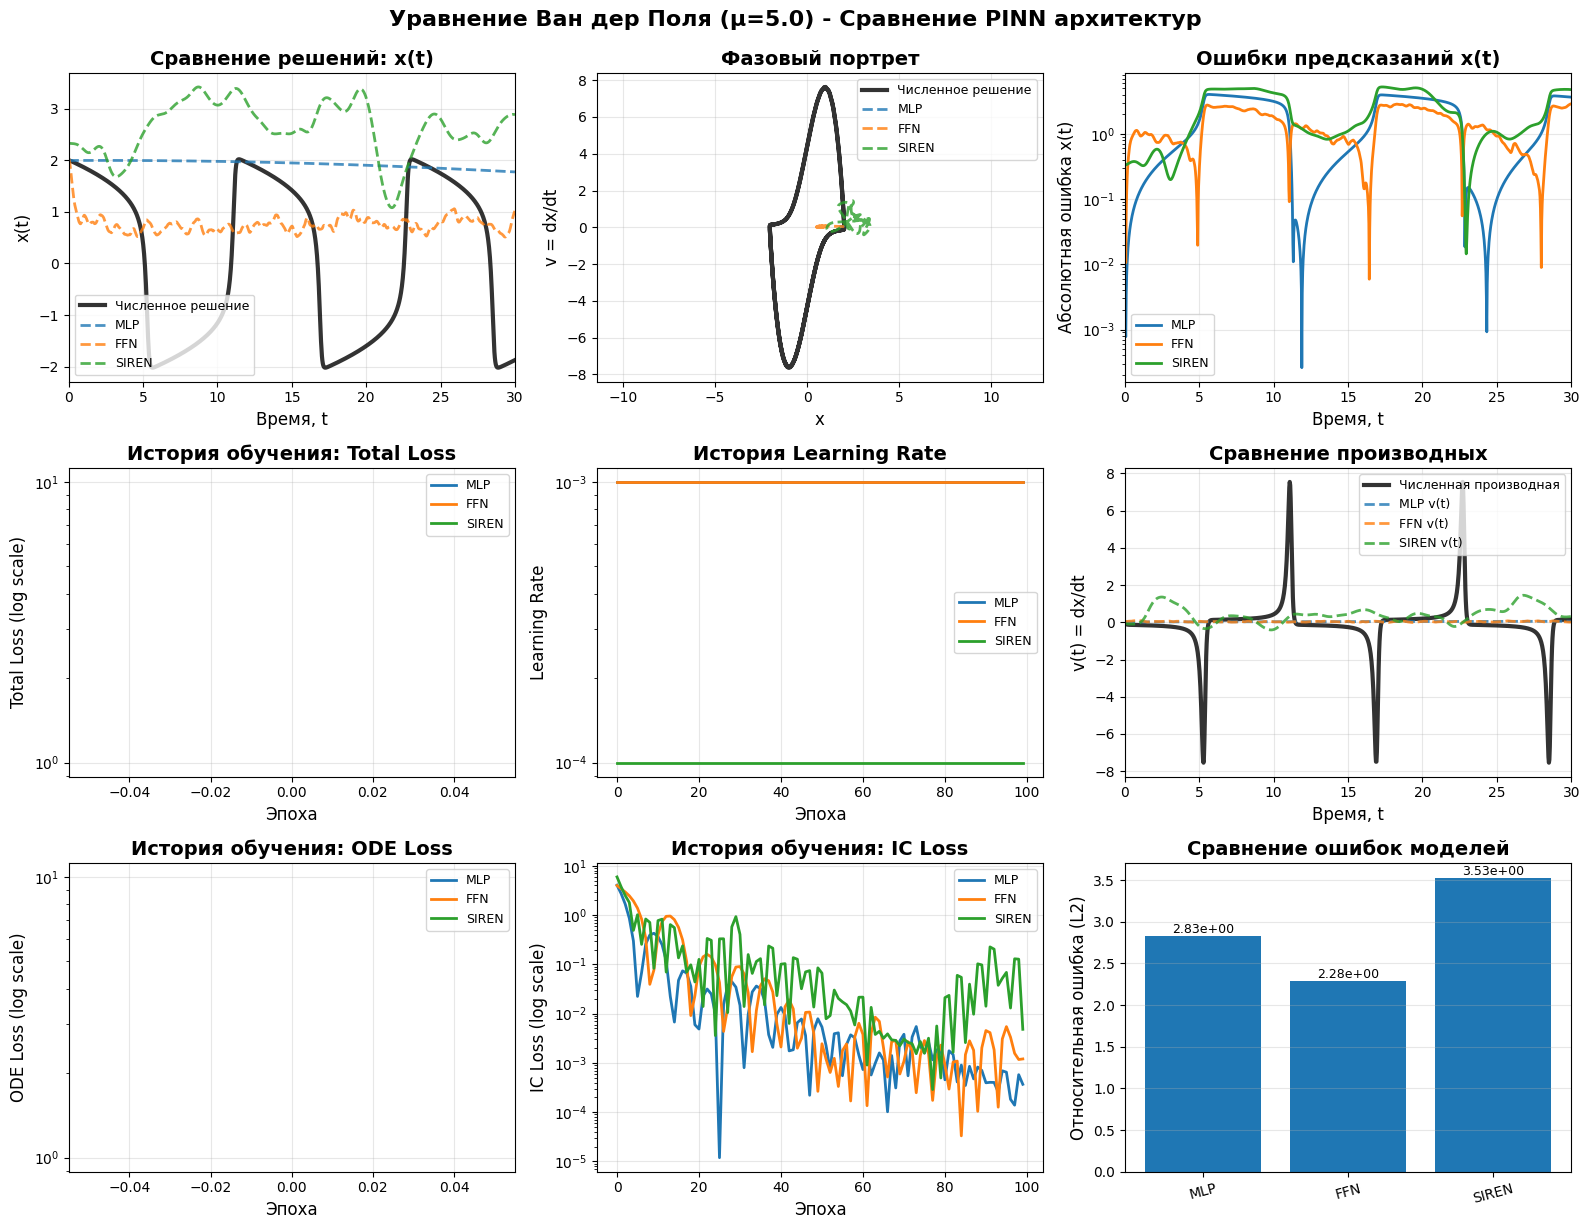


Анализ завершен!

ИТОГОВАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ
Модель                    Error x         Error v         Total Error    
----------------------------------------------------------------------
MLP                       2.3703e+00      1.5498e+00      2.8320e+00     
FFN                       1.6738e+00      1.5540e+00      2.2840e+00     
SIREN                     3.0660e+00      1.7499e+00      3.5302e+00     


In [ ]:

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# -------------------------------
# 1. Численное решение (эталон)
# -------------------------------
mu = 5.0

def vdp_ode(t, z):
    x, v = z
    return [v, mu * (1 - x**2) * v - x]

t_span = (0, 30)
t_eval = np.linspace(0, 30, 1000)
sol = solve_ivp(vdp_ode, t_span, [2.0, 0.0], t_eval=t_eval, rtol=1e-12, atol=1e-14)
t_num = sol.t
x_num = sol.y[0]
v_num = sol.y[1]

# -------------------------------
# 2. Архитектуры нейросетей
# -------------------------------

class MLP(nn.Module):
    """Стандартный полносвязный перцептрон с активациями Tanh"""
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 2)
        )
    def forward(self, t):
        return self.net(t)

class FourierFeatures(nn.Module):
    """Fourier feature embedding для лучшего обучения высокочастотных функций"""
    def __init__(self, input_dim=1, num_features=25, scale=15.0):
        super().__init__()
        self.register_buffer('B', torch.randn(input_dim, num_features) * scale)
    def forward(self, x):
        x_proj = 2 * np.pi * x @ self.B
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

class FFN(nn.Module):
    """Многослойный перцептрон с Fourier features"""
    def __init__(self, num_features=25, hidden_dim=128, scale=15.0):
        super().__init__()
        self.embed = FourierFeatures(input_dim=1, num_features=num_features, scale=scale)
        self.net = nn.Sequential(
            nn.Linear(2 * num_features, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2)
        )
    def forward(self, t):
        return self.net(self.embed(t))

class SineLayer(nn.Module):
    """SIREN слой с синусной активацией"""
    def __init__(self, in_f, out_f, is_first=False, omega_0=30.0):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        self.in_f = in_f
        self.linear = nn.Linear(in_f, out_f)
        self.init_weights()
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_f, 1 / self.in_f)
            else:
                self.linear.weight.uniform_(
                    -np.sqrt(6 / self.in_f) / self.omega_0,
                    np.sqrt(6 / self.in_f) / self.omega_0
                )
    def forward(self, x):
        return torch.sin(self.omega_0 * self.linear(x))

class SIREN(nn.Module):
    """SIREN модель для представления сигналов"""
    def __init__(self, hidden_dim=128, omega_0=30.0):
        super().__init__()
        self.net = nn.Sequential(
            SineLayer(1, hidden_dim, is_first=True, omega_0=omega_0),
            SineLayer(hidden_dim, hidden_dim, is_first=False, omega_0=omega_0),
            SineLayer(hidden_dim, hidden_dim, is_first=False, omega_0=omega_0),
            SineLayer(hidden_dim, hidden_dim, is_first=False, omega_0=omega_0),
            nn.Linear(hidden_dim, 2)
        )
        with torch.no_grad():
            self.net[-1].weight.uniform_(-np.sqrt(6 / hidden_dim), np.sqrt(6 / hidden_dim))
    def forward(self, t):
        return self.net(t)

# -------------------------------
# 3. Улучшенная функция обучения с адаптивной перетренировкой
# -------------------------------

def train_pinn_adaptive(model, name, device, mu=5.0, max_epochs=5000, lr=1e-3, ic_weight=1e4):
    """
    Обучение PINN с адаптивным перевыбором точек тренировки

    Args:
        model: нейросетевая модель
        name: имя модели для вывода
        device: CPU или GPU
        mu: параметр уравнения Ван дер Поля
        max_epochs: максимальное количество эпох
        lr: начальный learning rate
        ic_weight: вес условия в начальный момент времени
    """
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=200
    )

    best_loss = float('inf')
    best_model_state = None
    patience = 100
    counter = 0

    # Нормализация времени для улучшения сходимости
    t_min, t_max = 0.0, 30.0
    t_scale = t_max - t_min

    # Начальная равномерная сетка
    n_initial = 600
    t_train = torch.linspace(t_min, t_max, n_initial, device=device).unsqueeze(1)

    print(f"\n{'='*50}")
    print(f"Обучение {name}")
    print(f"{'='*50}")

    history = {'loss': [], 'lr': [], 'loss_ode': [], 'loss_ic': []}

    for epoch in range(max_epochs):
        model.train()
        optimizer.zero_grad()

        # Нормализуем время
        t_normalized = (t_train - t_min) / t_scale
        t_normalized.requires_grad_(True)

        # Forward pass
        out = model(t_normalized)
        x, v = out[:, 0:1], out[:, 1:2]

        # Вычисляем производные x и v по времени
        outputs = torch.cat([x, v], dim=1)
        grads = torch.autograd.grad(
            outputs, t_normalized,
            grad_outputs=torch.ones_like(outputs),
            create_graph=True,
            retain_graph=True
        )[0]
        dx_normalized, dv_normalized = grads[:, 0:1], grads[:, 1:2]

        # Пересчитываем производные для ненормализованного времени
        dx = dx_normalized / t_scale
        dv = dv_normalized / t_scale

        # Уравнение Ван дер Поля
        f1 = dx - v
        f2 = dv - (mu * (1 - x**2) * v - x)
        loss_ode = torch.mean(f1**2 + f2**2)

        # Начальные условия
        ic_t = torch.tensor([[0.0]], device=device)
        ic_t_normalized = (ic_t - t_min) / t_scale
        ic_pred = model(ic_t_normalized)
        loss_ic = (ic_pred[0, 0] - 2.0)**2 + (ic_pred[0, 1] - 0.0)**2

        # Общий loss
        loss = loss_ode + ic_weight * loss_ic

        # Backward pass
        loss.backward()

        # Gradient clipping для стабильности
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step(loss)

        # Сохраняем историю
        history['loss'].append(loss.item())
        history['loss_ode'].append(loss_ode.item())
        history['loss_ic'].append(loss_ic.item())
        history['lr'].append(optimizer.param_groups[0]['lr'])

        # Сохраняем лучшую модель
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_model_state = model.state_dict().copy()
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f"  → Ранняя остановка на эпохе {epoch}")
                break

        # Адаптивная перетренировка на эпохе 1000
        if epoch == 1000:
            print("  → Запуск адаптивной перетренировки...")
            model.eval()  # Переводим модель в режим оценки
            with torch.no_grad():
                # Создаем плотную сетку для оценки невязок
                n_dense = 2000
                t_dense = torch.linspace(t_min, t_max, n_dense, device=device).unsqueeze(1)
                t_dense_normalized = (t_dense - t_min) / t_scale

                # Предсказание на плотной сетке
                out_dense = model(t_dense_normalized)
                x_d, v_d = out_dense[:, 0:1], out_dense[:, 1:2]

                # Вычисляем производные численно (центральные разности)
                dt = t_dense[1, 0] - t_dense[0, 0]

                # Используем центральные разности для более точной оценки
                dx_num = torch.zeros_like(x_d)
                dv_num = torch.zeros_like(v_d)

                # Внутренние точки - центральные разности
                dx_num[1:-1] = (x_d[2:] - x_d[:-2]) / (2 * dt)
                dv_num[1:-1] = (v_d[2:] - v_d[:-2]) / (2 * dt)

                # Граничные точки - односторонние разности
                dx_num[0] = (x_d[1] - x_d[0]) / dt
                dx_num[-1] = (x_d[-1] - x_d[-2]) / dt
                dv_num[0] = (v_d[1] - v_d[0]) / dt
                dv_num[-1] = (v_d[-1] - v_d[-2]) / dt

                # Вычисляем невязки уравнения
                f1_res = dx_num - v_d
                f2_res = dv_num - (mu * (1 - x_d**2) * v_d - x_d)
                residuals = torch.abs(f1_res) + torch.abs(f2_res)

                # Выбираем точки с наибольшими невязками
                k = max(100, int(0.2 * len(residuals)))  # минимум 100 точек
                _, topk_idx = torch.topk(residuals.squeeze(), k)

                # Добавляем дополнительные точки для покрытия всего интервала
                t_selected = t_dense[topk_idx].clone()

                # Добавляем равномерные точки для стабильности
                n_uniform = max(200, k // 2)
                t_uniform = torch.linspace(t_min, t_max, n_uniform, device=device).unsqueeze(1)

                # Добавляем граничные точки для лучшего соблюдения условий
                t_boundary = torch.tensor([[t_min], [t_max]], device=device)

                # Объединяем все точки
                t_train_new = torch.cat([t_selected, t_uniform, t_boundary], dim=0)
                t_train_new = torch.unique(t_train_new, dim=0)  # Удаляем дубликаты

                # Обновляем тренировочные точки
                t_train = t_train_new.clone().detach()

                # Уменьшаем learning rate для тонкой настройки
                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr * 0.1

                print(f"  → Выбрано {k} точек с максимальной невязкой")
                print(f"  → Всего тренировочных точек: {len(t_train)}")
                print(f"  → Новый learning rate: {optimizer.param_groups[0]['lr']:.2e}")

            model.train()  # Возвращаем модель в режим обучения

        # Логирование прогресса
        if epoch % 500 == 0 or epoch == max_epochs - 1:
            current_lr = optimizer.param_groups[0]['lr']
            print(f"  Эпоха {epoch:4d}: loss = {loss.item():.3e}, "
                  f"loss_ode = {loss_ode.item():.3e}, "
                  f"loss_ic = {loss_ic.item():.3e}, "
                  f"LR = {current_lr:.1e}")

    # Загружаем лучшие веса модели
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    print(f"  {name} завершено за {epoch} эпох")
    print(f"  Финальный loss = {loss.item():.3e}")
    print(f"  Лучший loss = {best_loss:.3e}")

    return model, history

# -------------------------------
# 4. Запуск обучения всех моделей
# -------------------------------

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nИспользуемое устройство: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Создаем и обучаем модели
models = {}
histories = {}

# MLP
print("\n" + "="*60)
mlp_model = MLP(hidden_dim=128)
models['MLP'], histories['MLP'] = train_pinn_adaptive(
    mlp_model, 'MLP (Tanh)', device,
    lr=1e-3, ic_weight=1e4, max_epochs=3000
)

# FFN с Fourier features
print("\n" + "="*60)
ffn_model = FFN(num_features=30, hidden_dim=256, scale=20.0)
models['FFN'], histories['FFN'] = train_pinn_adaptive(
    ffn_model, 'FFN (Fourier Features)', device,
    lr=1e-3, ic_weight=5e3, max_epochs=3000
)

# SIREN
print("\n" + "="*60)
siren_model = SIREN(hidden_dim=128, omega_0=30.0)
models['SIREN'], histories['SIREN'] = train_pinn_adaptive(
    siren_model, 'SIREN', device,
    lr=1e-4, ic_weight=1e4, max_epochs=3000
)

# -------------------------------
# 5. Оценка и визуализация результатов
# -------------------------------

# Подготовка тестовых данных
t_test = torch.linspace(0, 30, 1000, device=device).unsqueeze(1)
t_test_normalized = (t_test - 0) / 30.0  # Нормализация

results = {'Численное': (x_num, v_num)}

print("\n" + "="*60)
print("Получение предсказаний моделей...")

with torch.no_grad():
    for name, model in models.items():
        model.eval()
        pred = model(t_test_normalized)
        x_pred = pred[:, 0].cpu().numpy()
        v_pred = pred[:, 1].cpu().numpy()
        results[name] = (x_pred, v_pred)
        print(f"  {name}: предсказания получены")
        model.train()

# Вычисление ошибок
print("\n" + "="*60)
print("Ошибки предсказаний (L2 норма):")
print("-"*60)

t_test_cpu = t_test.cpu().numpy().flatten()
for name, (x_pred, v_pred) in results.items():
    if name != 'Численное':
        # Интерполируем численное решение на те же точки
        from scipy.interpolate import interp1d
        f_x = interp1d(t_num, x_num, kind='cubic', fill_value='extrapolate')
        f_v = interp1d(t_num, v_num, kind='cubic', fill_value='extrapolate')

        x_num_interp = f_x(t_test_cpu)
        v_num_interp = f_v(t_test_cpu)

        # Вычисляем ошибки
        error_x = np.sqrt(np.mean((x_pred - x_num_interp)**2))
        error_v = np.sqrt(np.mean((v_pred - v_num_interp)**2))
        error_total = np.sqrt(error_x**2 + error_v**2)

        print(f"  {name:25s}: error_x = {error_x:.4e}, error_v = {error_v:.4e}, total = {error_total:.4e}")

# -------------------------------
# 6. Визуализация результатов
# -------------------------------

plt.figure(figsize=(16, 12))

# 6.1. x(t) - сравнение всех моделей
plt.subplot(3, 3, 1)
plt.plot(t_num, x_num, 'k-', linewidth=3, label='Численное решение', alpha=0.8)
for name, (x, v) in results.items():
    if name != 'Численное':
        plt.plot(t_test_cpu, x, '--', linewidth=2, label=name, alpha=0.8)
plt.xlabel('Время, t', fontsize=12)
plt.ylabel('x(t)', fontsize=12)
plt.title('Сравнение решений: x(t)', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=9)
plt.grid(True, alpha=0.3)
plt.xlim(0, 30)

# 6.2. Фазовый портрет
plt.subplot(3, 3, 2)
plt.plot(x_num, v_num, 'k-', linewidth=3, label='Численное решение', alpha=0.8)
for name, (x, v) in results.items():
    if name != 'Численное':
        plt.plot(x, v, '--', linewidth=2, label=name, alpha=0.8)
plt.xlabel('x', fontsize=12)
plt.ylabel('v = dx/dt', fontsize=12)
plt.title('Фазовый портрет', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=9)
plt.grid(True, alpha=0.3)
plt.axis('equal')

# 6.3. Ошибки моделей по времени
plt.subplot(3, 3, 3)
for name, (x_pred, v_pred) in results.items():
    if name != 'Численное':
        # Интерполируем численное решение
        f_x = interp1d(t_num, x_num, kind='cubic', fill_value='extrapolate')
        x_num_interp = f_x(t_test_cpu)
        error = np.abs(x_pred - x_num_interp)
        plt.plot(t_test_cpu, error, linewidth=2, label=f'{name}')
plt.xlabel('Время, t', fontsize=12)
plt.ylabel('Абсолютная ошибка x(t)', fontsize=12)
plt.title('Ошибки предсказаний x(t)', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=9)
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.xlim(0, 30)

# 6.4. История обучения (loss)
plt.subplot(3, 3, 4)
for name, history in histories.items():
    epochs = range(len(history['loss']))
    plt.semilogy(epochs, history['loss'], linewidth=2, label=name)
plt.xlabel('Эпоха', fontsize=12)
plt.ylabel('Total Loss (log scale)', fontsize=12)
plt.title('История обучения: Total Loss', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=9)
plt.grid(True, alpha=0.3)

# 6.5. История learning rate
plt.subplot(3, 3, 5)
for name, history in histories.items():
    epochs = range(len(history['lr']))
    plt.plot(epochs, history['lr'], linewidth=2, label=name)
plt.xlabel('Эпоха', fontsize=12)
plt.ylabel('Learning Rate', fontsize=12)
plt.title('История Learning Rate', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=9)
plt.grid(True, alpha=0.3)
plt.yscale('log')

# 6.6. Сравнение производных
plt.subplot(3, 3, 6)
# Вычисляем производную от численного решения
dt_num = t_num[1] - t_num[0]
v_num_centered = np.gradient(x_num, dt_num)

plt.plot(t_num, v_num_centered, 'k-', linewidth=3, label='Численная производная', alpha=0.8)
for name, (x, v) in results.items():
    if name != 'Численное':
        plt.plot(t_test_cpu, v, '--', linewidth=2, label=f'{name} v(t)', alpha=0.8)
plt.xlabel('Время, t', fontsize=12)
plt.ylabel('v(t) = dx/dt', fontsize=12)
plt.title('Сравнение производных', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=9)
plt.grid(True, alpha=0.3)
plt.xlim(0, 30)

# 6.7. История loss_ode
plt.subplot(3, 3, 7)
for name, history in histories.items():
    epochs = range(len(history['loss_ode']))
    plt.semilogy(epochs, history['loss_ode'], linewidth=2, label=name)
plt.xlabel('Эпоха', fontsize=12)
plt.ylabel('ODE Loss (log scale)', fontsize=12)
plt.title('История обучения: ODE Loss', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=9)
plt.grid(True, alpha=0.3)

# 6.8. История loss_ic
plt.subplot(3, 3, 8)
for name, history in histories.items():
    epochs = range(len(history['loss_ic']))
    plt.semilogy(epochs, history['loss_ic'], linewidth=2, label=name)
plt.xlabel('Эпоха', fontsize=12)
plt.ylabel('IC Loss (log scale)', fontsize=12)
plt.title('История обучения: IC Loss', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=9)
plt.grid(True, alpha=0.3)

# 6.9. Относительные ошибки
plt.subplot(3, 3, 9)
names_list = []
errors_list = []
for name, (x_pred, v_pred) in results.items():
    if name != 'Численное':
        f_x = interp1d(t_num, x_num, kind='cubic', fill_value='extrapolate')
        f_v = interp1d(t_num, v_num, kind='cubic', fill_value='extrapolate')
        x_num_interp = f_x(t_test_cpu)
        v_num_interp = f_v(t_test_cpu)
        rel_error = np.sqrt(np.mean((x_pred - x_num_interp)**2 + (v_pred - v_num_interp)**2))
        names_list.append(name)
        errors_list.append(rel_error)

bars = plt.bar(names_list, errors_list)
plt.ylabel('Относительная ошибка (L2)', fontsize=12)
plt.title('Сравнение ошибок моделей', fontsize=14, fontweight='bold')
plt.xticks(rotation=15)
plt.grid(True, alpha=0.3, axis='y')

# Добавляем значения на столбцы
for bar, error in zip(bars, errors_list):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f'{error:.2e}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.suptitle(f'Уравнение Ван дер Поля (μ={mu}) - Сравнение PINN архитектур',
             fontsize=16, fontweight='bold', y=1.02)
plt.show()

# Дополнительная визуализация: адаптивные точки
print("\n" + "="*60)
print("Анализ завершен!")
print("="*60)

# Финальная таблица результатов
print("\n" + "="*60)
print("ИТОГОВАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ")
print("="*60)
print(f"{'Модель':<25} {'Error x':<15} {'Error v':<15} {'Total Error':<15}")
print("-"*70)
for name, (x_pred, v_pred) in results.items():
    if name != 'Численное':
        f_x = interp1d(t_num, x_num, kind='cubic', fill_value='extrapolate')
        f_v = interp1d(t_num, v_num, kind='cubic', fill_value='extrapolate')
        x_num_interp = f_x(t_test_cpu)
        v_num_interp = f_v(t_test_cpu)
        error_x = np.sqrt(np.mean((x_pred - x_num_interp)**2))
        error_v = np.sqrt(np.mean((v_pred - v_num_interp)**2))
        error_total = np.sqrt(error_x**2 + error_v**2)
        print(f"{name:<25} {error_x:<15.4e} {error_v:<15.4e} {error_total:<15.4e}")
print("="*70)


Устройство: cpu


Предобучение Simple MLP...
  Эпоха 0: MSE = 2.451748
  Эпоха 200: MSE = 2.165354
  Эпоха 400: MSE = 1.671705
  Эпоха 600: MSE = 1.031941
  Предобучение завершено. MSE = 0.796092


Предобучение Residual MLP...
  Эпоха 0: MSE = 2.452572
  Эпоха 200: MSE = 1.955986
  Эпоха 400: MSE = 1.062194
  Эпоха 600: MSE = 0.866655
  Предобучение завершено. MSE = 0.746465

Дообучение как PINN...

Дообучение Simple MLP как PINN...

Обучение Simple MLP...
  Эпоха 0: loss = 1377.933716, ODE = 1376.579468, IC = 0.013451
  Эпоха 500: loss = 6.055270, ODE = 5.968413, IC = 0.008172
  Эпоха 1000: loss = 1.380439, ODE = 1.361754, IC = 0.001403
  Обучение завершено. Финальный loss = 0.889746

Дообучение Residual MLP как PINN...

Обучение Residual MLP...
  Эпоха 0: loss = 1049.551392, ODE = 1040.252808, IC = 0.092900
  Эпоха 500: loss = 4.132583, ODE = 4.077308, IC = 0.004992
  Эпоха 1000: loss = 2.416056, ODE = 2.406555, IC = 0.000498
  Обучение завершено. Финальный loss = 2.151798

Оценка р

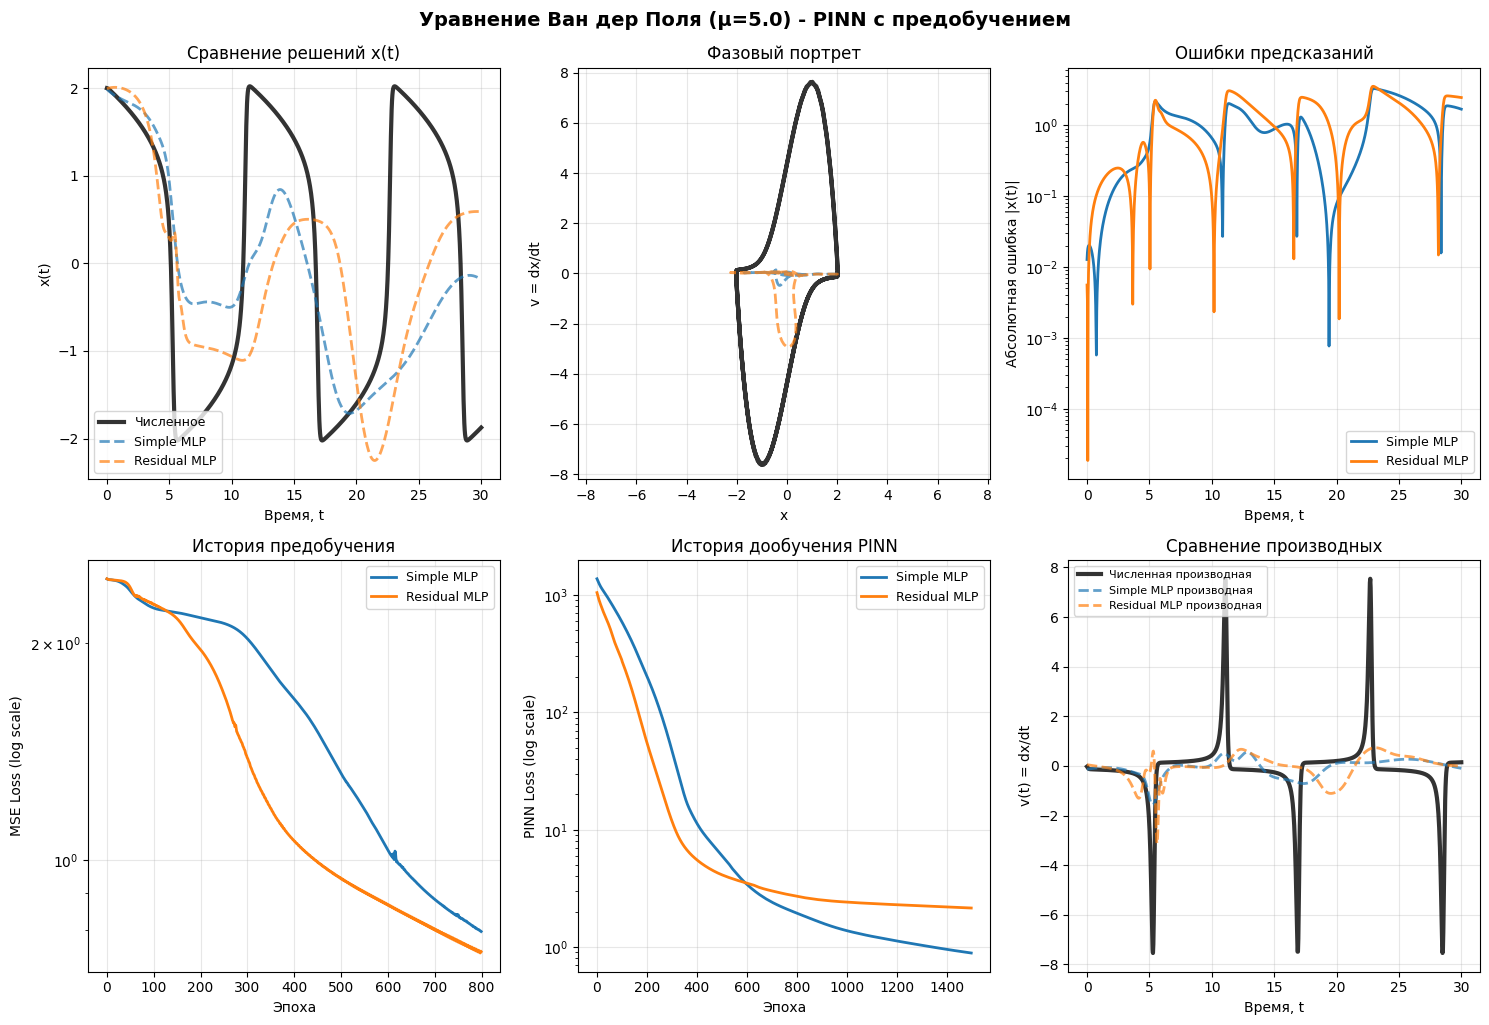


Анализ остатков уравнений...


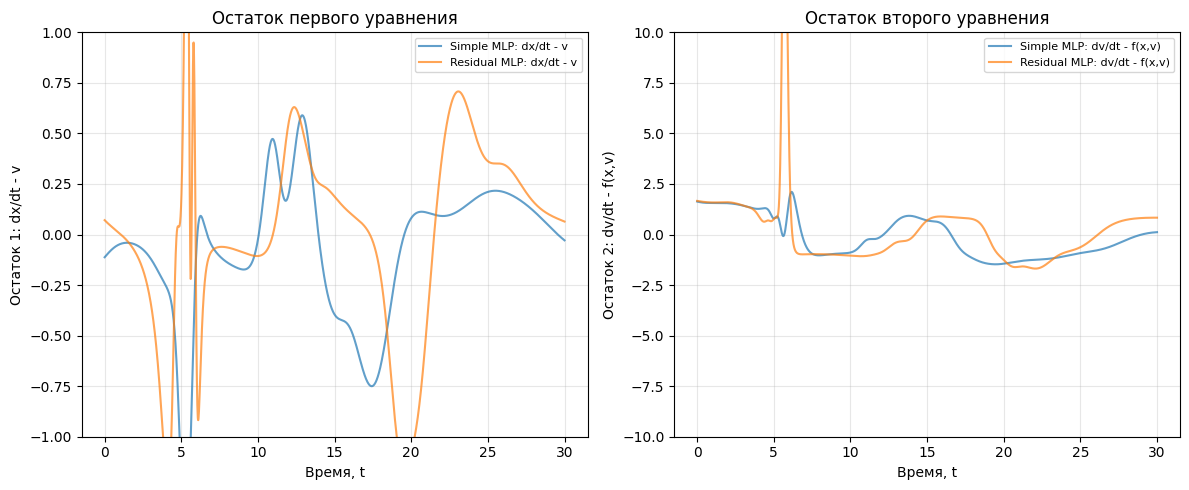


Дополнительный анализ...


/tmp/ipython-input-389082804.py:551: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(model_names, rotation=15)


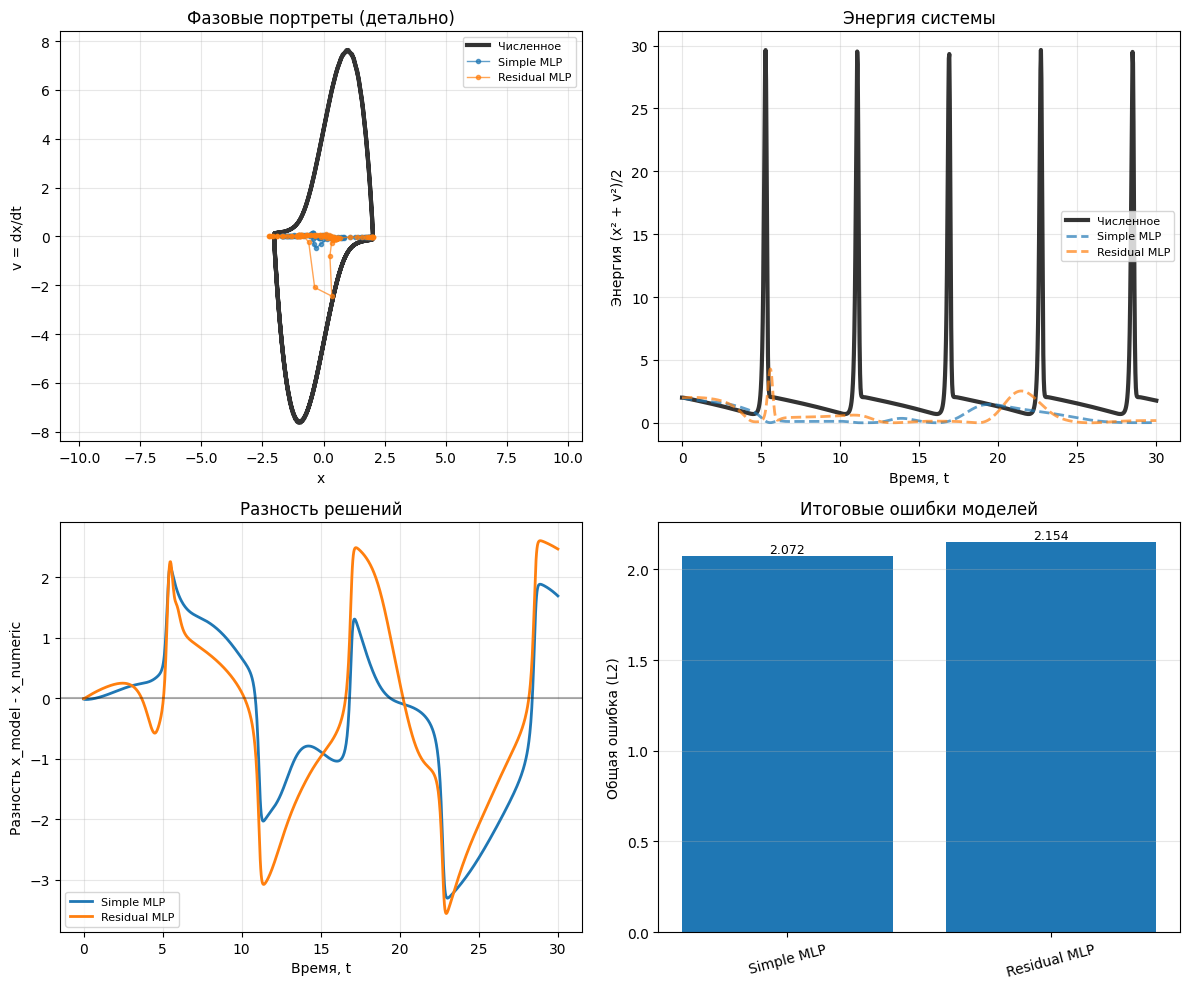


Сводка результатов:
Параметр уравнения Ван дер Поля: μ = 5.0
Начальные условия: x(0) = 2.0, v(0) = 0.0
Интервал времени: [0, 30]

Лучшая модель по общей ошибке:
  Simple MLP: ошибка = 2.0717

Анализ завершен!


In [ ]:

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# -------------------------------
# 1. Численное решение (эталон)
# -------------------------------
mu = 5.0

def vdp_ode(t, z):
    x, v = z
    return [v, mu * (1 - x**2) * v - x]

t_span = (0, 30)
t_eval = np.linspace(0, 30, 1000)
sol = solve_ivp(vdp_ode, t_span, [2.0, 0.0], t_eval=t_eval, rtol=1e-12, atol=1e-14)
t_num = sol.t
x_num = sol.y[0]
v_num = sol.y[1]

# -------------------------------
# 2. Простые архитектуры с гарантированной стабильностью
# -------------------------------

class SimpleMLP(nn.Module):
    """Очень простая и стабильная MLP"""
    def __init__(self, hidden_dim=32):
        super().__init__()
        # Маленькие веса для стабильности
        self.fc1 = nn.Linear(1, hidden_dim)
        self.act1 = nn.Tanh()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.act2 = nn.Tanh()
        self.fc3 = nn.Linear(hidden_dim, 2)

        # Инициализация с очень маленькими весами
        nn.init.uniform_(self.fc1.weight, -0.1, 0.1)
        nn.init.uniform_(self.fc2.weight, -0.1, 0.1)
        nn.init.uniform_(self.fc3.weight, -0.01, 0.01)  # Очень маленькие на выходе
        nn.init.constant_(self.fc1.bias, 0.0)
        nn.init.constant_(self.fc2.bias, 0.0)
        nn.init.constant_(self.fc3.bias, 0.0)

    def forward(self, t):
        x = self.act1(self.fc1(t))
        x = self.act2(self.fc2(x))
        return self.fc3(x)

class ResidualMLP(nn.Module):
    """MLP с residual connections для лучшего обучения"""
    def __init__(self, hidden_dim=32):
        super().__init__()
        self.fc1 = nn.Linear(1, hidden_dim)
        self.act1 = nn.Tanh()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.act2 = nn.Tanh()
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.act3 = nn.Tanh()
        self.fc_out = nn.Linear(hidden_dim, 2)

        # Инициализация
        for layer in [self.fc1, self.fc2, self.fc3]:
            nn.init.uniform_(layer.weight, -0.05, 0.05)
            nn.init.constant_(layer.bias, 0.0)
        nn.init.uniform_(self.fc_out.weight, -0.005, 0.005)
        nn.init.constant_(self.fc_out.bias, 0.0)

    def forward(self, t):
        x = self.act1(self.fc1(t))
        residual = x
        x = self.act2(self.fc2(x))
        x = self.act3(self.fc3(x + residual))  # Residual connection
        return self.fc_out(x)

# -------------------------------
# 3. ОЧЕНЬ простая функция обучения
# -------------------------------

def train_simple_pinn(model, name, device, mu=5.0, epochs=2000, lr=1e-4):
    """
    Простейшее обучение PINN без сложных трюков
    """
    print(f"\nОбучение {name}...")

    model.to(device)

    # Очень маленький learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Простая сетка точек
    t_train = torch.linspace(0, 30, 500, device=device).unsqueeze(1)
    t_train.requires_grad = True

    # Начальные условия
    t0 = torch.tensor([[0.0]], device=device, requires_grad=True)

    history = []

    for epoch in range(epochs):
        optimizer.zero_grad()

        # 1. Ограничиваем выход модели
        out = model(t_train)
        x, v = out[:, 0:1], out[:, 1:2]

        # 2. Ограничиваем значения (предотвращаем взрыв)
        x = torch.tanh(x) * 3.0  # Ограничиваем x между -3 и 3
        v = torch.tanh(v) * 3.0  # Ограничиваем v между -3 и 3

        # 3. Вычисляем производные
        dx = torch.autograd.grad(x, t_train, torch.ones_like(x), create_graph=True)[0]
        dv = torch.autograd.grad(v, t_train, torch.ones_like(v), create_graph=True)[0]

        # 4. Уравнение
        f1 = dx - v
        f2 = dv - (mu * (1 - x**2) * v - x)

        # 5. Loss с регуляризацией
        loss_ode = torch.mean(f1**2) + torch.mean(f2**2)

        # 6. Начальные условия
        out0 = model(t0)
        x0, v0 = out0[0, 0], out0[0, 1]
        loss_ic = (x0 - 2.0)**2 + (v0 - 0.0)**2

        # 7. Общий loss (начальные условия важнее в начале)
        ic_weight = 100.0 if epoch < 100 else 10.0
        loss = loss_ode + ic_weight * loss_ic

        # 8. Регуляризация выходов
        loss += 0.001 * (torch.mean(x**2) + torch.mean(v**2))

        # Проверка на NaN
        if torch.isnan(loss):
            print(f"  NaN обнаружен на эпохе {epoch}, сбрасываю модель...")
            # Переинициализируем веса
            for layer in model.children():
                if hasattr(layer, 'reset_parameters'):
                    layer.reset_parameters()
            continue

        loss.backward()

        # 9. Жесткий clipping градиентов
        torch.nn.utils.clip_grad_value_(model.parameters(), 0.1)

        optimizer.step()

        history.append(loss.item())

        if epoch % 500 == 0:
            print(f"  Эпоха {epoch}: loss = {loss.item():.6f}, "
                  f"ODE = {loss_ode.item():.6f}, IC = {loss_ic.item():.6f}")

    print(f"  Обучение завершено. Финальный loss = {loss.item():.6f}")
    return model, history

# -------------------------------
# 4. Альтернативный подход: обучение с учителем сначала
# -------------------------------

def pretrain_with_supervision(model, name, device, epochs=1000):
    """
    Предобучение на численном решении (с учителем)
    """
    print(f"\nПредобучение {name}...")

    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    # Подготовка данных
    t_tensor = torch.tensor(t_num, dtype=torch.float32, device=device).unsqueeze(1)
    x_tensor = torch.tensor(x_num, dtype=torch.float32, device=device).unsqueeze(1)
    v_tensor = torch.tensor(v_num, dtype=torch.float32, device=device).unsqueeze(1)
    target = torch.cat([x_tensor, v_tensor], dim=1)

    history = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(t_tensor)
        loss = criterion(output, target)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        history.append(loss.item())

        if epoch % 200 == 0:
            print(f"  Эпоха {epoch}: MSE = {loss.item():.6f}")

    print(f"  Предобучение завершено. MSE = {loss.item():.6f}")
    return model, history

# -------------------------------
# 5. Основное обучение
# -------------------------------

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nУстройство: {device}")

# Создаем модели
models = {}
histories_pretrain = {}
histories_finetune = {}

# Простая MLP
print("\n" + "="*60)
simple_mlp = SimpleMLP(hidden_dim=64)
models['Simple MLP'], histories_pretrain['Simple MLP'] = pretrain_with_supervision(
    simple_mlp, 'Simple MLP', device, epochs=800
)

# Residual MLP
print("\n" + "="*60)
residual_mlp = ResidualMLP(hidden_dim=64)
models['Residual MLP'], histories_pretrain['Residual MLP'] = pretrain_with_supervision(
    residual_mlp, 'Residual MLP', device, epochs=800
)

# -------------------------------
# 6. Дообучение как PINN
# -------------------------------

print("\n" + "="*60)
print("Дообучение как PINN...")
print("="*60)

for name, model in models.items():
    print(f"\nДообучение {name} как PINN...")
    model, history_finetune = train_simple_pinn(
        model, name, device, mu=5.0, epochs=1500, lr=5e-5
    )
    histories_finetune[name] = history_finetune
    models[name] = model

# -------------------------------
# 7. Оценка результатов
# -------------------------------

print("\n" + "="*60)
print("Оценка результатов...")
print("="*60)

# Тестовые данные
t_test = torch.linspace(0, 30, 1000, device=device).unsqueeze(1)
t_test_np = t_test.cpu().numpy().flatten()

results = {'Численное': (x_num, v_num)}

with torch.no_grad():
    for name, model in models.items():
        model.eval()
        pred = model(t_test)
        x_pred = pred[:, 0].cpu().numpy()
        v_pred = pred[:, 1].cpu().numpy()
        results[name] = (x_pred, v_pred)

# Вычисление ошибок
print("\nОшибки предсказаний (L2 норма):")
print("-"*50)

for name, (x_pred, v_pred) in results.items():
    if name != 'Численное':
        # Интерполяция численного решения
        from scipy.interpolate import interp1d
        f_x = interp1d(t_num, x_num, kind='cubic')
        f_v = interp1d(t_num, v_num, kind='cubic')

        x_num_interp = f_x(t_test_np)
        v_num_interp = f_v(t_test_np)

        error_x = np.sqrt(np.mean((x_pred - x_num_interp)**2))
        error_v = np.sqrt(np.mean((v_pred - v_num_interp)**2))
        error_total = np.sqrt(error_x**2 + error_v**2)

        print(f"{name:15s}: x_error = {error_x:.4e}, v_error = {error_v:.4e}, total = {error_total:.4e}")

# -------------------------------
# 8. Визуализация
# -------------------------------

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. x(t)
ax = axes[0, 0]
ax.plot(t_num, x_num, 'k-', linewidth=3, label='Численное', alpha=0.8)
for name, (x, v) in results.items():
    if name != 'Численное':
        ax.plot(t_test_np, x, '--', linewidth=2, label=name, alpha=0.7)
ax.set_xlabel('Время, t')
ax.set_ylabel('x(t)')
ax.set_title('Сравнение решений x(t)')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# 2. Фазовый портрет
ax = axes[0, 1]
ax.plot(x_num, v_num, 'k-', linewidth=3, label='Численное', alpha=0.8)
for name, (x, v) in results.items():
    if name != 'Численное':
        ax.plot(x, v, '--', linewidth=2, label=name, alpha=0.7)
ax.set_xlabel('x')
ax.set_ylabel('v = dx/dt')
ax.set_title('Фазовый портрет')
ax.grid(True, alpha=0.3)
ax.axis('equal')

# 3. Ошибки по времени
ax = axes[0, 2]
for name, (x_pred, v_pred) in results.items():
    if name != 'Численное':
        f_x = interp1d(t_num, x_num, kind='cubic')
        x_num_interp = f_x(t_test_np)
        error = np.abs(x_pred - x_num_interp)
        ax.plot(t_test_np, error, linewidth=2, label=name)
ax.set_xlabel('Время, t')
ax.set_ylabel('Абсолютная ошибка |x(t)|')
ax.set_title('Ошибки предсказаний')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

# 4. История предобучения
ax = axes[1, 0]
for name, history in histories_pretrain.items():
    epochs = range(len(history))
    ax.semilogy(epochs, history, linewidth=2, label=name)
ax.set_xlabel('Эпоха')
ax.set_ylabel('MSE Loss (log scale)')
ax.set_title('История предобучения')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# 5. История дообучения PINN
ax = axes[1, 1]
for name, history in histories_finetune.items():
    epochs = range(len(history))
    ax.semilogy(epochs, history, linewidth=2, label=name)
ax.set_xlabel('Эпоха')
ax.set_ylabel('PINN Loss (log scale)')
ax.set_title('История дообучения PINN')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# 6. Сравнение производных (исправленная версия)
ax = axes[1, 2]
# Численная производная
dt_num = t_num[1] - t_num[0]
v_num_centered = np.gradient(x_num, dt_num)

ax.plot(t_num, v_num_centered, 'k-', linewidth=3, label='Численная производная', alpha=0.8)

# Производные моделей
for name, model in models.items():
    model.eval()
    # Создаем новый тензор с requires_grad для каждой модели
    t_test_grad = torch.linspace(0, 30, 1000, device=device).unsqueeze(1)
    t_test_grad.requires_grad = True

    # Forward pass
    out = model(t_test_grad)
    x_model = out[:, 0:1]

    # Вычисляем производную
    dx_model = torch.autograd.grad(
        x_model,
        t_test_grad,
        grad_outputs=torch.ones_like(x_model),
        create_graph=False,
        retain_graph=True
    )[0]

    ax.plot(t_test_grad.detach().cpu().numpy().flatten(),
           dx_model.detach().cpu().numpy().flatten(),
           '--', linewidth=2, label=f'{name} производная', alpha=0.7)

    # Очищаем граф вычислений
    del t_test_grad, out, x_model, dx_model
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

ax.set_xlabel('Время, t')
ax.set_ylabel('v(t) = dx/dt')
ax.set_title('Сравнение производных')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle(f'Уравнение Ван дер Поля (μ={mu}) - PINN с предобучением',
             fontsize=14, fontweight='bold', y=1.02)
plt.show()

# -------------------------------
# 9. Анализ остатков уравнений (исправленная версия)
# -------------------------------

print("\n" + "="*60)
print("Анализ остатков уравнений...")
print("="*60)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for name, model in models.items():
    model.eval()

    # Создаем новый тензор для каждой модели
    t_dense = torch.linspace(0, 30, 2000, device=device).unsqueeze(1)
    t_dense.requires_grad = True

    # Forward pass
    out = model(t_dense)
    x, v = out[:, 0:1], out[:, 1:2]

    # Вычисляем производные
    dx = torch.autograd.grad(
        x, t_dense,
        grad_outputs=torch.ones_like(x),
        create_graph=False,
        retain_graph=True
    )[0]

    dv = torch.autograd.grad(
        v, t_dense,
        grad_outputs=torch.ones_like(v),
        create_graph=False,
        retain_graph=True
    )[0]

    # Остатки уравнений
    residual1 = dx - v
    residual2 = dv - (mu * (1 - x**2) * v - x)

    t_dense_np = t_dense.detach().cpu().numpy().flatten()

    ax = axes[0]
    ax.plot(t_dense_np, residual1.detach().cpu().numpy(),
           linewidth=1.5, label=f'{name}: dx/dt - v', alpha=0.7)

    ax = axes[1]
    ax.plot(t_dense_np, residual2.detach().cpu().numpy(),
           linewidth=1.5, label=f'{name}: dv/dt - f(x,v)', alpha=0.7)

    # Очищаем граф вычислений
    del t_dense, out, x, v, dx, dv, residual1, residual2
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

axes[0].set_xlabel('Время, t')
axes[0].set_ylabel('Остаток 1: dx/dt - v')
axes[0].set_title('Остаток первого уравнения')
axes[0].legend(fontsize=8)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(-1, 1)

axes[1].set_xlabel('Время, t')
axes[1].set_ylabel('Остаток 2: dv/dt - f(x,v)')
axes[1].set_title('Остаток второго уравнения')
axes[1].legend(fontsize=8)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(-10, 10)

plt.tight_layout()
plt.show()

# -------------------------------
# 10. Дополнительный анализ
# -------------------------------

print("\n" + "="*60)
print("Дополнительный анализ...")
print("="*60)

# Создаем сетку для оценки
t_eval = torch.linspace(0, 30, 100, device=device).unsqueeze(1)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Сравнение фазовых портретов в деталях
ax = axes[0, 0]
ax.plot(x_num, v_num, 'k-', linewidth=3, label='Численное', alpha=0.8)
for name, model in models.items():
    model.eval()
    with torch.no_grad():
        out = model(t_eval)
        x_pred = out[:, 0].cpu().numpy()
        v_pred = out[:, 1].cpu().numpy()
        ax.plot(x_pred, v_pred, 'o-', linewidth=1, markersize=3, label=name, alpha=0.7)
ax.set_xlabel('x')
ax.set_ylabel('v = dx/dt')
ax.set_title('Фазовые портреты (детально)')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)
ax.axis('equal')

# 2. Энергия системы (x² + v²)/2
ax = axes[0, 1]
energy_num = 0.5 * (x_num**2 + v_num**2)
ax.plot(t_num, energy_num, 'k-', linewidth=3, label='Численное', alpha=0.8)

for name, model in models.items():
    model.eval()
    with torch.no_grad():
        out = model(t_test)
        x_pred = out[:, 0].cpu().numpy()
        v_pred = out[:, 1].cpu().numpy()
        energy_pred = 0.5 * (x_pred**2 + v_pred**2)
        ax.plot(t_test_np, energy_pred, '--', linewidth=2, label=name, alpha=0.7)
ax.set_xlabel('Время, t')
ax.set_ylabel('Энергия (x² + v²)/2')
ax.set_title('Энергия системы')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# 3. Разность между моделями и численным решением
ax = axes[1, 0]
for name, (x_pred, v_pred) in results.items():
    if name != 'Численное':
        f_x = interp1d(t_num, x_num, kind='cubic')
        x_num_interp = f_x(t_test_np)
        diff = x_pred - x_num_interp
        ax.plot(t_test_np, diff, linewidth=2, label=name)
ax.set_xlabel('Время, t')
ax.set_ylabel('Разность x_model - x_numeric')
ax.set_title('Разность решений')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)

# 4. Сходимость обучения
ax = axes[1, 1]
final_errors = []
model_names = []

for name, (x_pred, v_pred) in results.items():
    if name != 'Численное':
        f_x = interp1d(t_num, x_num, kind='cubic')
        f_v = interp1d(t_num, v_num, kind='cubic')
        x_num_interp = f_x(t_test_np)
        v_num_interp = f_v(t_test_np)
        error = np.sqrt(np.mean((x_pred - x_num_interp)**2 + (v_pred - v_num_interp)**2))
        final_errors.append(error)
        model_names.append(name)

bars = ax.bar(model_names, final_errors)
ax.set_ylabel('Общая ошибка (L2)')
ax.set_title('Итоговые ошибки моделей')
ax.set_xticklabels(model_names, rotation=15)
ax.grid(True, alpha=0.3, axis='y')

# Добавляем значения на столбцы
for bar, error in zip(bars, final_errors):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
            f'{error:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("Сводка результатов:")
print("="*60)
print(f"Параметр уравнения Ван дер Поля: μ = {mu}")
print(f"Начальные условия: x(0) = 2.0, v(0) = 0.0")
print(f"Интервал времени: [0, 30]")
print("\nЛучшая модель по общей ошибке:")
best_idx = np.argmin(final_errors)
print(f"  {model_names[best_idx]}: ошибка = {final_errors[best_idx]:.4f}")

print("\n" + "="*60)
print("Анализ завершен!")
print("="*60)